In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%capture
!pip install mne

In [3]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.io import loadmat
from glob import glob
import mne
import tensorflow as tf

In [4]:
!unzip gdrive/My\ Drive/Data/ADHD_data.zip

Archive:  gdrive/My Drive/Data/ADHD_data.zip
   creating: ADHD_data/adhd/
  inflating: ADHD_data/adhd/1 (1).mat  
  inflating: ADHD_data/adhd/1 (10).mat  
  inflating: ADHD_data/adhd/1 (11).mat  
  inflating: ADHD_data/adhd/1 (12).mat  
  inflating: ADHD_data/adhd/1 (13).mat  
  inflating: ADHD_data/adhd/1 (14).mat  
  inflating: ADHD_data/adhd/1 (15).mat  
  inflating: ADHD_data/adhd/1 (16).mat  
  inflating: ADHD_data/adhd/1 (17).mat  
  inflating: ADHD_data/adhd/1 (18).mat  
  inflating: ADHD_data/adhd/1 (19).mat  
  inflating: ADHD_data/adhd/1 (2).mat  
  inflating: ADHD_data/adhd/1 (20).mat  
  inflating: ADHD_data/adhd/1 (21).mat  
  inflating: ADHD_data/adhd/1 (22).mat  
  inflating: ADHD_data/adhd/1 (23).mat  
  inflating: ADHD_data/adhd/1 (24).mat  
  inflating: ADHD_data/adhd/1 (25).mat  
  inflating: ADHD_data/adhd/1 (26).mat  
  inflating: ADHD_data/adhd/1 (27).mat  
  inflating: ADHD_data/adhd/1 (28).mat  
  inflating: ADHD_data/adhd/1 (29).mat  
  inflating: ADHD_data/adh

In [5]:
adhd_path='/content/ADHD_data/adhd'
healthy_path='/content/ADHD_data/healthy'

In [6]:
def convertmat2mne(data):
  ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']
  ch_types = ['eeg'] * 19
  sampling_freq=128
  info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1020')
  data=mne.io.RawArray(data, info)
  data.set_eeg_reference()
  data.filter(l_freq=1,h_freq=50)
  epochs=mne.make_fixed_length_epochs(data,duration=3,overlap=0)
  return epochs.get_data()

In [7]:
%%capture
adhd_subject=[]
for adhd in glob(adhd_path+'/*.mat'):
  data=scipy.io.loadmat(adhd)['sinyal']
  data=data.T
  print(data.shape)
  data=convertmat2mne(data)
  adhd_subject.append(data)

In [8]:
%%capture
healthy_subject=[]
for healthy in glob(healthy_path+'/*.mat'):
  data=scipy.io.loadmat(healthy)['sinyal']
  data=data.T
  data=convertmat2mne(data)
  healthy_subject.append(data)

In [9]:
len(adhd_subject), len(healthy_subject)

(61, 60)

In [10]:
control_epochs_labels=[len(i)*[0] for i in healthy_subject]
patients_epochs_labels=[len(i)*[1] for i in adhd_subject]
print(len(control_epochs_labels),len(patients_epochs_labels))

60 61


In [11]:
data_list=healthy_subject+adhd_subject
label_list=control_epochs_labels+patients_epochs_labels
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]
print(len(data_list),len(label_list),len(groups_list))

121 121 121


In [12]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [14]:
import numpy as np
data_array=np.concatenate(data_list)
label_array=np.concatenate(label_list)
group_array=np.concatenate(groups_list)
data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape)

(5588, 384, 19) (5588,) (5588,)


In [15]:
data_array

array([[[ 8.17124146e-14, -6.25277607e-13,  2.77111667e-13, ...,
          1.98951966e-13,  6.18172180e-13,  1.49213975e-13],
        [ 1.62341836e+03, -2.85463285e+03,  1.69602696e+03, ...,
          1.91993654e+03,  1.91763303e+03,  1.82210961e+03],
        [ 1.67137918e+03, -2.83030473e+03,  1.71005453e+03, ...,
          1.81878014e+03,  1.78768468e+03,  1.76943188e+03],
        ...,
        [-5.45151217e+01,  4.17687801e+01,  7.91187556e+01, ...,
         -6.37252019e+01, -6.61068009e+01,  7.38737795e-01],
        [-6.03931936e+01,  2.92094426e+01,  7.05971761e+01, ...,
          1.35505565e+01,  7.76828785e+01,  3.39940393e+01],
        [-1.58383485e+02,  4.41888956e+01, -3.37682068e+01, ...,
          4.36463384e+01,  7.63025591e+01,  3.65886134e+01]],

       [[-1.28864131e+02,  6.30410451e+01, -4.77510241e-01, ...,
          4.68946765e+01,  1.12837206e+02, -1.16938261e+00],
        [-1.88487055e+02,  1.40712966e+01, -2.45399315e+01, ...,
          4.96944321e+01,  1.53336719e

In [16]:
accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler3D()
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)

In [17]:
train_features.shape

(4475, 384, 19)

In [18]:
from tensorflow import keras

In [28]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

from tensorflow.python.keras.engine.sequential import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D, LSTM
#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
def block(input):
  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

In [21]:
input= Input(shape=(384,19))
block1=block(input)
block2=block(block1)
block3=block(block2)

In [29]:
gru_out1 = LSTM(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = LSTM(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = LSTM(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = LSTM(32,activation='tanh')(gru_out)

In [30]:
predictions = Dense(1,activation='sigmoid')(gru_out4)
model = Model(inputs=input, outputs=predictions)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [31]:
history=model.fit(train_features,train_labels,epochs=10,batch_size=32,validation_data=(val_features,val_labels))

Epoch 1/10
140/140 [==============================] - 61s 269ms/step - loss: 0.0708 - accuracy: 0.9803 - val_loss: 0.3681 - val_accuracy: 0.9155
Epoch 2/10
140/140 [==============================] - 34s 243ms/step - loss: 0.0349 - accuracy: 0.9911 - val_loss: 0.2900 - val_accuracy: 0.8949
Epoch 3/10
140/140 [==============================] - 37s 265ms/step - loss: 0.0094 - accuracy: 0.9984 - val_loss: 0.2356 - val_accuracy: 0.9461
Epoch 4/10
140/140 [==============================] - 34s 246ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.1690 - val_accuracy: 0.9623
Epoch 5/10
140/140 [==============================] - 35s 247ms/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.2513 - val_accuracy: 0.9173
Epoch 6/10
140/140 [==============================] - 34s 245ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.2690 - val_accuracy: 0.9380
Epoch 7/10
140/140 [==============================] - 34s 245ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.2789 - val_ac

In [32]:
test_loss, test_acc = model.evaluate(val_features,val_labels, verbose=2)

35/35 - 1s - loss: 0.2818 - accuracy: 0.9515


In [33]:
print(test_acc)

0.9514824748039246


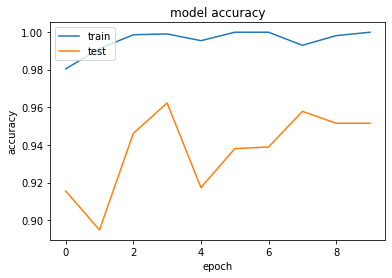

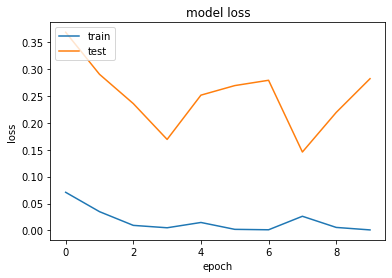

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()